<a href="https://colab.research.google.com/github/jangelcode/super-duper/blob/main/honorsthesis/ESA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

# Setting up the Data

In [ ]:
data = pd.read_csv("ESA_District_NoPriv.csv")
df = pd.DataFrame(data)
print(df.head())
dataTypeSeries = data.dtypes
print(dataTypeSeries)

      School District or Charter Holder  ... Average Scholarship
0  Agua Fria Union High School District  ...            24743.36
1                  Ajo Unified District  ...             7252.13
2          Alhambra Elementary District  ...            10425.30
3      Altar Valley Elementary District  ...            16582.20
4         Amphitheater Unified District  ...            11945.08

[5 rows x 9 columns]
School District or Charter Holder                           object
Percent DF Schools                                          object
Poverty Rate                                                object
Special Ed Population                                       object
Students in District                                         int64
Spending Per Pupil                                           int64
Total Value of ESA Scholarships                            float64
Students using ESA to leave district for private school      int64
Average Scholarship                                 

Two data points have NA's so I am dropping them from the data set.

I'm also creating the ESA participation rate by dividing students using the program by total students in the district.

In [ ]:
df = df.drop([7,12])
df["ESA_Part_Rate"] = df['Students using ESA to leave district for private school']/df['Students in District']

Because the data contained some NA values some of the columns had data type object instead of numeric

In [ ]:
import statistics as stat
df['ESA_Part_Rate'] = pd.to_numeric(df['ESA_Part_Rate'])
df['Poverty Rate'] = pd.to_numeric(df['Poverty Rate'])
df['Special Ed Population'] = pd.to_numeric(df['Special Ed Population'])
df['Percent DF Schools'] = pd.to_numeric(df['Percent DF Schools'])
print(df.head())
stat.median(df['Poverty Rate'])

      School District or Charter Holder  ...  ESA_Part_Rate
0  Agua Fria Union High School District  ...       0.002297
1                  Ajo Unified District  ...       0.002375
2          Alhambra Elementary District  ...       0.002346
3      Altar Valley Elementary District  ...       0.003289
4         Amphitheater Unified District  ...       0.006086

[5 rows x 10 columns]


0.215

# Regression Set up

The special ed population and percent D/F grade schools should be useful controls since "of 692 students using ESAs in March 2014, 549 are students with a disability, 92 attend D/F schools, 39 are foster/adopted children and 12 are children of military families."

The main variable of interest is the impact of poverty rate on ESA Participation.

In [ ]:
df['Povrate2'] = df['Poverty Rate']**2
X = df[['Percent DF Schools', 'Poverty Rate', 'Special Ed Population']]

## Test for multicollinearity using VIF values.

The VIF shows poverty rate and special ed population explain a moderate amount of the same variation. This implies the model suffers from some multicollinearity.

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif.round(1))

   VIF Factor               features
0         1.7     Percent DF Schools
1         5.4           Poverty Rate
2         4.8  Special Ed Population


## First Regression

In [ ]:
X = sm.add_constant(X)
y = df['ESA_Part_Rate']
model1 = sm.OLS(y, X).fit(cov_type='HC3')
print(model1.summary())
#Y = C + Need + Rich + Need*Rich + e

                            OLS Regression Results                            
Dep. Variable:          ESA_Part_Rate   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     1.918
Date:                Mon, 26 Oct 2020   Prob (F-statistic):              0.130
Time:                        04:59:05   Log-Likelihood:                 451.23
No. Observations:                 140   AIC:                            -894.5
Df Residuals:                     136   BIC:                            -882.7
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

# Testing the Model

## RESET TEST
Testing if the model is misspecified, we use the RESET Test, assuming zero conditional mean holds.

At the 5% significance level we would reject the null hypothesis that the coefficient for the square of our models predictions is equal to zero.

This indicates that the model is misspecified which is not a surprise
since only one of the variables appear to have significant coefficients.

In [ ]:
df['predictions'] = model1.predict()
df['predictions2'] = df['predictions']*df['predictions']
X = df[['Poverty Rate', 'Special Ed Population', 'Percent DF Schools', 'predictions2']]
X = sm.add_constant(X)
y = df['ESA_Part_Rate']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          ESA_Part_Rate   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     11.03
Date:                Mon, 26 Oct 2020   Prob (F-statistic):           9.00e-08
Time:                        04:59:08   Log-Likelihood:                 459.10
No. Observations:                 140   AIC:                            -908.2
Df Residuals:                     135   BIC:                            -893.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

## Residual Plots
Check for correlation with error term in original model that would violate the zero conditional mean assumption.

I would say the errors look mostly random and about 4 or 5 very large residuals make the graphs slightly deceiving.


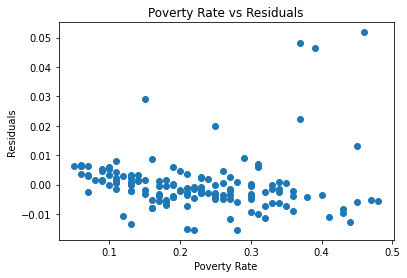

In [ ]:
z = 'Residuals'
X = df['Poverty Rate']
y = model1.resid
plt.scatter(X,y)
plt.ylabel(z)
plt.xlabel(X.name)
plt.title(X.name + ' vs ' + z)
plt.show()

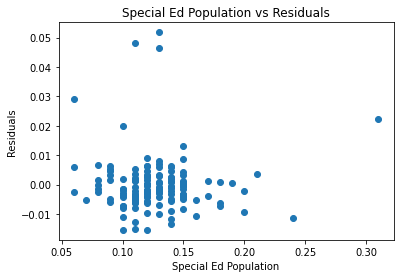

In [ ]:
X = df['Special Ed Population']
plt.scatter(X,y)
plt.ylabel(z)
plt.xlabel(X.name)
plt.title(X.name + ' vs ' + z)
plt.show()

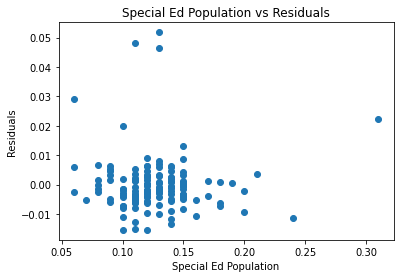

In [ ]:
plt.scatter(X,y)
plt.ylabel(z)
plt.xlabel(X.name)
plt.title(X.name + ' vs ' + z)
plt.show()

## Linearity

Plotting variables against ESA participation rate to visualize relationship and check for linearity.

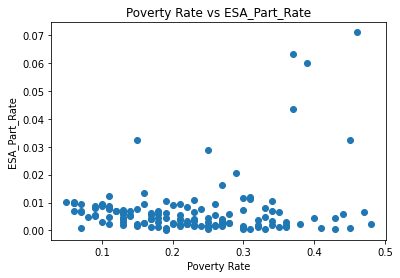

In [ ]:
y = df['ESA_Part_Rate']
z = y.name
X = df['Poverty Rate']
plt.scatter(X,y)
plt.ylabel(z)
plt.xlabel(X.name)
plt.title(X.name + ' vs ' + z)
plt.show()

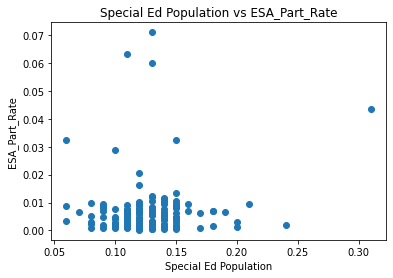

In [ ]:
X = df['Special Ed Population']
plt.scatter(X,y)
plt.ylabel(z)
plt.xlabel(X.name)
plt.title(X.name + ' vs ' + z)
plt.show()

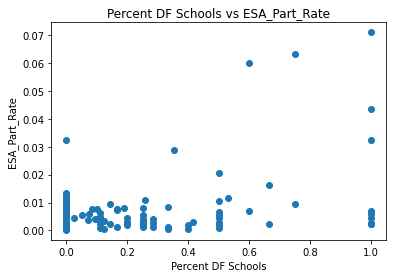

In [ ]:
X = df['Percent DF Schools']
plt.scatter(X,y)
plt.ylabel(z)
plt.xlabel(X.name)
plt.title(X.name + ' vs ' + z)
plt.show()

# New and Improved Model

Now I will regress the ESA participation rate on the expanded form of the RESET test and remove variables with insignificant coefficients.

In [ ]:
a = df['Poverty Rate']
b = df['Special Ed Population']
c = df['Percent DF Schools']
df['Povrate2'] = a*a
df['Specpop2'] = b*b
df['DFschool2'] = c*c
df['PovrateSpec'] = a*b
df['PovrateDF'] = a*c
df['SpecDF'] = b*c
X = df[['Poverty Rate', 'Special Ed Population', 'Percent DF Schools', 'Povrate2', 
        'Specpop2', 'DFschool2','PovrateSpec', 'PovrateDF', 'SpecDF']]
X = sm.add_constant(X)
y = df['ESA_Part_Rate']
model1 = sm.OLS(y, X).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:          ESA_Part_Rate   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     9.443
Date:                Mon, 26 Oct 2020   Prob (F-statistic):           5.70e-11
Time:                        04:59:21   Log-Likelihood:                 474.51
No. Observations:                 140   AIC:                            -929.0
Df Residuals:                     130   BIC:                            -899.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

In [ ]:
X = df[['Poverty Rate', 'Special Ed Population', 'Percent DF Schools', 'Povrate2', 
        'Specpop2', 'DFschool2', 'PovrateDF', 'SpecDF']]
X = sm.add_constant(X)
y = df['ESA_Part_Rate']
model1 = sm.OLS(y, X).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:          ESA_Part_Rate   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     10.69
Date:                Mon, 26 Oct 2020   Prob (F-statistic):           1.74e-11
Time:                        04:59:22   Log-Likelihood:                 474.46
No. Observations:                 140   AIC:                            -930.9
Df Residuals:                     131   BIC:                            -904.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

In [ ]:
X = df[['Special Ed Population', 'Percent DF Schools', 'Povrate2', 
        'Specpop2', 'DFschool2', 'PovrateDF', 'SpecDF']]
X = sm.add_constant(X)
y = df['ESA_Part_Rate']
model1 = sm.OLS(y, X).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:          ESA_Part_Rate   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     12.30
Date:                Mon, 26 Oct 2020   Prob (F-statistic):           4.78e-12
Time:                        04:59:24   Log-Likelihood:                 474.44
No. Observations:                 140   AIC:                            -932.9
Df Residuals:                     132   BIC:                            -909.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

This appears to be the correct model specification since it passed the RESET test this time

# Guass-Markov Assumptions

It appears that the model satisfies the assumptions:

- Linear in parameters. (MLR.1)
- Independent obsevations of the population. (MLR.2)
- No perfect collinearity. (MLR.3)
- The error u has an expected value of zero given any values of the independent variables. (MLR.4)
- The error u has the same variance given any value of the explanatory variables. (MLR.5)




# New Models

In [ ]:
#Y = C + Need + Rich + Need*Rich + e
df['PovrateSpecEd'] = df['Poverty Rate']*df['Special Ed Population']
X = df[['Poverty Rate','Special Ed Population','PovrateSpecEd']]
y = df['ESA_Part_Rate']
model1 = sm.OLS(y, X).fit(cov_type='HC3')
print(model1.summary())

                                 OLS Regression Results                                
Dep. Variable:          ESA_Part_Rate   R-squared (uncentered):                   0.363
Model:                            OLS   Adj. R-squared (uncentered):              0.349
Method:                 Least Squares   F-statistic:                              46.84
Date:                Mon, 26 Oct 2020   Prob (F-statistic):                    6.71e-21
Time:                        04:59:28   Log-Likelihood:                          444.04
No. Observations:                 140   AIC:                                     -882.1
Df Residuals:                     137   BIC:                                     -873.3
Df Model:                           3                                                  
Covariance Type:                  HC3                                                  
                            coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

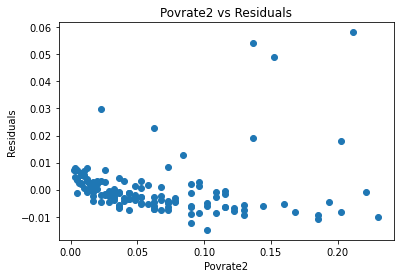

In [ ]:
z = 'Residuals'
X = df['Povrate2']
y = model1.resid
plt.scatter(X,y)
plt.ylabel(z)
plt.xlabel(X.name)
plt.title(X.name + ' vs ' + z)
plt.show()

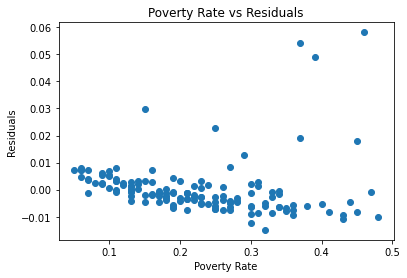

In [ ]:
X = df['Poverty Rate']
plt.scatter(X,y)
plt.ylabel(z)
plt.xlabel(X.name)
plt.title(X.name + ' vs ' + z)
plt.show()

In [ ]:
X = df[['Poverty Rate', 'Povrate2']]
y = df['ESA_Part_Rate']
model1 = sm.OLS(y, X).fit(cov_type='HC3')
print(model1.summary())

                                 OLS Regression Results                                
Dep. Variable:          ESA_Part_Rate   R-squared (uncentered):                   0.338
Model:                            OLS   Adj. R-squared (uncentered):              0.329
Method:                 Least Squares   F-statistic:                              44.03
Date:                Mon, 26 Oct 2020   Prob (F-statistic):                    1.62e-15
Time:                        04:59:32   Log-Likelihood:                          441.33
No. Observations:                 140   AIC:                                     -878.7
Df Residuals:                     138   BIC:                                     -872.8
Df Model:                           2                                                  
Covariance Type:                  HC3                                                  
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

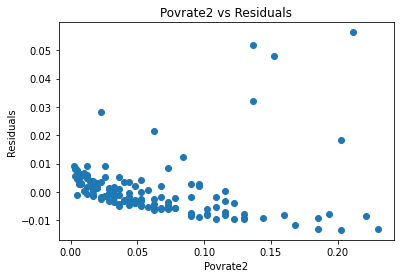

In [ ]:
z = 'Residuals'
X = df['Povrate2']
y = model1.resid
plt.scatter(X,y)
plt.ylabel(z)
plt.xlabel(X.name)
plt.title(X.name + ' vs ' + z)
plt.show()

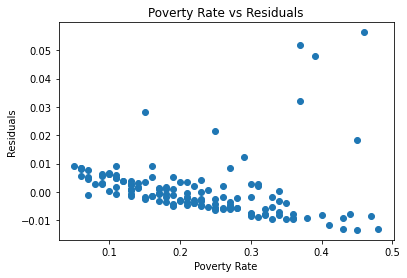

In [ ]:
X = df['Poverty Rate']
plt.scatter(X,y)
plt.ylabel(z)
plt.xlabel(X.name)
plt.title(X.name + ' vs ' + z)
plt.show()

# Final Model Used in Thesis

## Y = C + Need + Rich + Need*Rich

In [ ]:
import statistics as stat

stat.median(df['Poverty Rate'])
df["Rich"] = (df["Poverty Rate"] >= df["Poverty Rate"].median())*1

In [ ]:
#Y = C + Need + Rich + Need*Rich
df['RichSpecEd'] = df['Special Ed Population']*df['Rich']
X = df[['Rich','Special Ed Population','RichSpecEd']]
X = sm.add_constant(X)
y = df['ESA_Part_Rate']
model1 = sm.OLS(y, X).fit(cov_type='HC3')
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:          ESA_Part_Rate   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.046
Date:                Mon, 26 Oct 2020   Prob (F-statistic):              0.375
Time:                        04:59:39   Log-Likelihood:                 443.06
No. Observations:                 140   AIC:                            -878.1
Df Residuals:                     136   BIC:                            -866.4
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

In [ ]:
X = df['Special Ed Population']
X = sm.add_constant(X)
y = df['ESA_Part_Rate']
model1 = sm.OLS(y, X).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:          ESA_Part_Rate   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.926
Date:                Mon, 26 Oct 2020   Prob (F-statistic):              0.167
Time:                        04:59:41   Log-Likelihood:                 440.27
No. Observations:                 140   AIC:                            -876.5
Df Residuals:                     138   BIC:                            -870.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

In [ ]:
df['Proportion DF Schools'] = df['Percent DF Schools']

In [ ]:
#Y = C + Need + Rich + Need*Rich
df['RichDF'] = df['Proportion DF Schools']*df['Rich']
X = df[['Proportion DF Schools','Rich','RichDF']]
X = sm.add_constant(X)
y = df['ESA_Part_Rate']
model1 = sm.OLS(y, X).fit(cov_type='HC3')
print(model1.summary())

# Estimate on Proportion DF Schools not statistically diffent from 0

                            OLS Regression Results                            
Dep. Variable:          ESA_Part_Rate   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     3.577
Date:                Mon, 26 Oct 2020   Prob (F-statistic):             0.0157
Time:                        07:08:07   Log-Likelihood:                 461.69
No. Observations:                 140   AIC:                            -915.4
Df Residuals:                     136   BIC:                            -903.6
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

In [ ]:
X = df[['Proportion DF Schools','Rich']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif.round(1))

   VIF Factor               features
0         1.4  Proportion DF Schools
1         1.4                   Rich


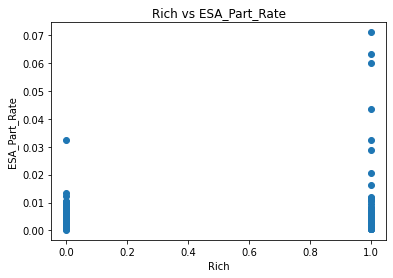

In [ ]:
y = df['ESA_Part_Rate']
z = y.name
X = df['Rich']
plt.scatter(X,y)
plt.ylabel(z)
plt.xlabel(X.name)
plt.title(X.name + ' vs ' + z)
plt.show()

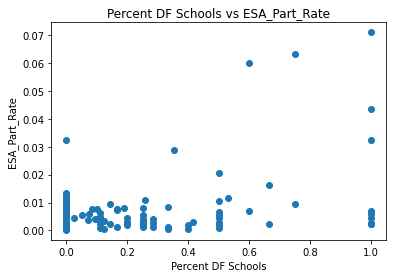

In [ ]:
X = df['Percent DF Schools']
plt.scatter(X,y)
plt.ylabel(z)
plt.xlabel(X.name)
plt.title(X.name + ' vs ' + z)
plt.show()

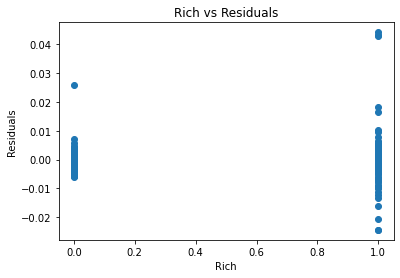

In [ ]:
z = 'Residuals'
X = df['Rich']
y = model1.resid
plt.scatter(X,y)
plt.ylabel(z)
plt.xlabel(X.name)
plt.title(X.name + ' vs ' + z)
plt.show()

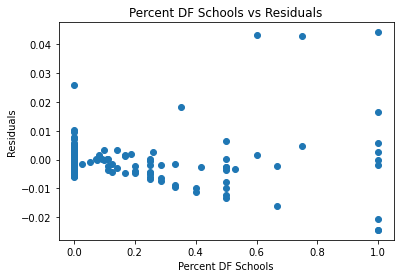

In [ ]:
X = df['Percent DF Schools']
plt.scatter(X,y)
plt.ylabel(z)
plt.xlabel(X.name)
plt.title(X.name + ' vs ' + z)
plt.show()

In [ ]:
import statistics as stats

stats.median(df['Percent DF Schools'])

0.0

In [ ]:
import pandas
df['Percent DF Schools'].quantile([0.25,0.5,0.75])

0.25    0.000000
0.50    0.000000
0.75    0.265873
Name: Percent DF Schools, dtype: float64

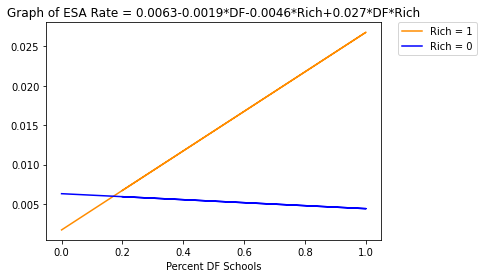

In [ ]:
DF = df['Percent DF Schools']
R1 = 1
y1 = 0.0063-0.0019*DF-0.0046*R1+0.027*DF*R1

DF = df['Percent DF Schools']
R2 = 0
y2 = 0.0063-0.0019*DF-0.0046*R2+0.027*DF*R2
plt.plot(DF,y1,label='Rich = 1', color = 'darkorange')
plt.plot(DF,y2,label='Rich = 0', color = 'blue')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel(X.name)
plt.title('Graph of ESA Rate = 0.0063-0.0019*DF-0.0046*Rich+0.027*DF*Rich')
plt.show()